#### Examples_Spike.ipynb

In this notebook, we set up central black hole, surrounded by a DM spike. We then evolve it forward to check for long term stability.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})

from NbodyIMRI import tools, particles, simulator, reader
from NbodyIMRI import units as u
from NbodyIMRI import distributionfunctions as DF
import NbodyIMRI

import copy

#### Setting up the system parameters


In [3]:
M_1 = 1e3*u.Msun

r_isco = 6*u.G_N*M_1/u.c**2

rho_6 = 1e16*u.Msun/u.pc**3 #Normalisation of the spike
gamma_sp = 7/3

N_DM = 10000

Here, we're initialising a DM spike with density profile:

$$ \rho(r) = \rho_6 (r/r_6)^{-\gamma_\mathrm{sp}}$$

with $r_6 = 10^{-6}\,\mathrm{pc}$. The power-law spike is formally infinite, so we have to truncate at some radius $r_\mathrm{max}$. 

#### Generating initial conditions

Here, we generate a single BH surrounded by a DM spike with a power-law profile:



> Particle set:
>     M_1 [M_sun] = 1000.0
 
>     N_DM = 10000
>     M_DM [M_sun] = 1.8849555921538758e-05


(<Figure size 1152x360 with 3 Axes>,
 array([<AxesSubplot:xlabel='$x$ [pc]', ylabel='$y$ [pc]'>,
        <AxesSubplot:xlabel='$x$ [pc]', ylabel='$z$ [pc]'>,
        <AxesSubplot:xlabel='$\\log_{10}(r/\\mathrm{pc})$', ylabel='$P(\\log_{10}(r/\\mathrm{pc}))$'>],
       dtype=object))

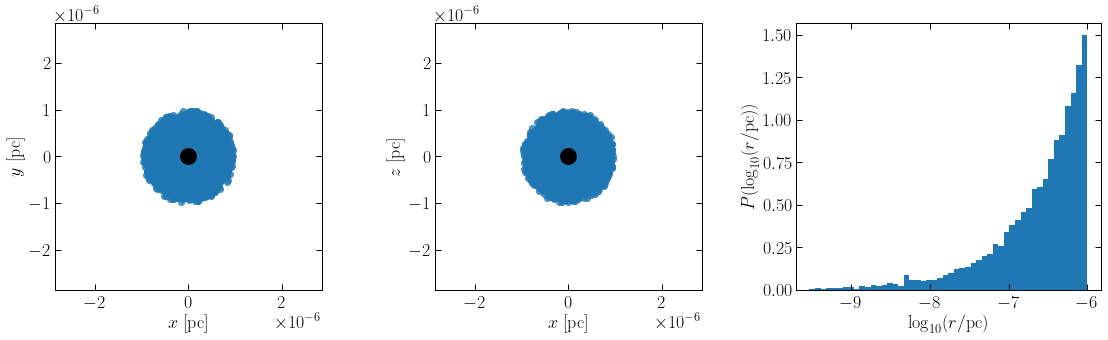

In [4]:
p_BH = particles.single_BH(M_1, N_DM = N_DM, rho_6 = rho_6, gamma_sp = gamma_sp, r_max = 1e-6*u.pc)

p_BH.summary()
p_BH.plot()

#### Setting up the simulator and simulation parameters

In [5]:
#Set the softening length
eps1 = 10*r_isco

#Initialise the simulator object by passing the particle set with the initial conditions
sim = simulator.simulator(p_BH, r_soft_sq1 = eps1**2)

#Let's estimate the orbital period at a distance of 1e-8 pc, to give us a sense of the timescales:
T_orb = tools.calc_Torb(a_i = 1e-9*u.pc, M_tot = M_1)

#Now let's evolve so that a typical particle at this radius orbits ~10 times
N_step_per_orb = 1000
N_orb = 10

t_end = T_orb*N_orb
dt    = T_orb/N_step_per_orb

#### Running the simulation

In [6]:
sim.run_simulation(dt, t_end, show_progress=True)

  0%|          | 26/10000 [00:00<00:39, 252.43it/s]

> Simulating...


100%|██████████| 10000/10000 [00:42<00:00, 234.80it/s]

> Simulation completed.


(<Figure size 1152x360 with 3 Axes>,
 array([<AxesSubplot:xlabel='$x$ [pc]', ylabel='$y$ [pc]'>,
        <AxesSubplot:xlabel='$x$ [pc]', ylabel='$z$ [pc]'>,
        <AxesSubplot:xlabel='$\\log_{10}(r/\\mathrm{pc})$', ylabel='$P(\\log_{10}(r/\\mathrm{pc}))$'>],
       dtype=object))

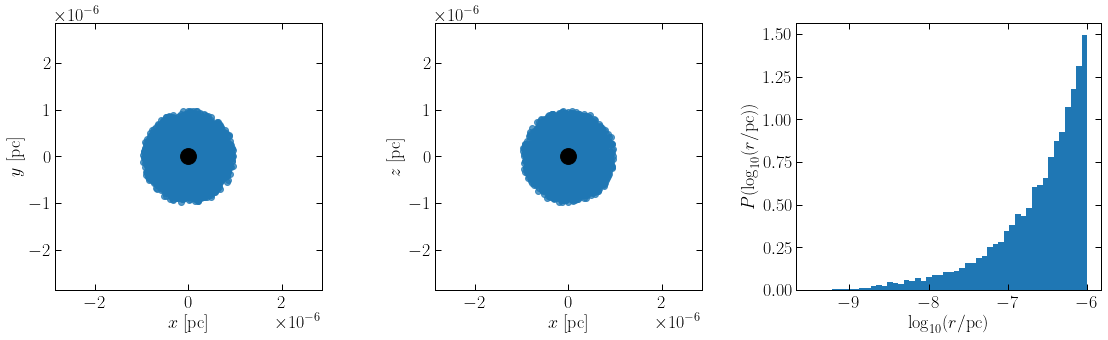

In [7]:
sim.p.plot()

#### A smoothly truncated density profile

This isn't too bad. But there's now a population of DM particles which are escaping to large radii! This is in part because we truncated our power-law spike, meaning that we didn't really have an equilibrium distribution in the first place. 

We can remedy this by using a *smoothly truncated* power-law density profile:

$$ \rho(r) = \rho_6 (r/r_6)^{-\gamma_\mathrm{sp}} (1 + r/r_t)^{-\alpha}$$

The truncation radius $r_t$ controls where the truncation kicks in. And the parameter $\alpha$ controls how quickly the density profile drops off. 

> Particle set:
>     M_1 [M_sun] = 1000.0
 
>     N_DM = 10000
>     M_DM [M_sun] = 1.0488337378336059e-05


(<Figure size 1152x360 with 3 Axes>,
 array([<AxesSubplot:xlabel='$x$ [pc]', ylabel='$y$ [pc]'>,
        <AxesSubplot:xlabel='$x$ [pc]', ylabel='$z$ [pc]'>,
        <AxesSubplot:xlabel='$\\log_{10}(r/\\mathrm{pc})$', ylabel='$P(\\log_{10}(r/\\mathrm{pc}))$'>],
       dtype=object))

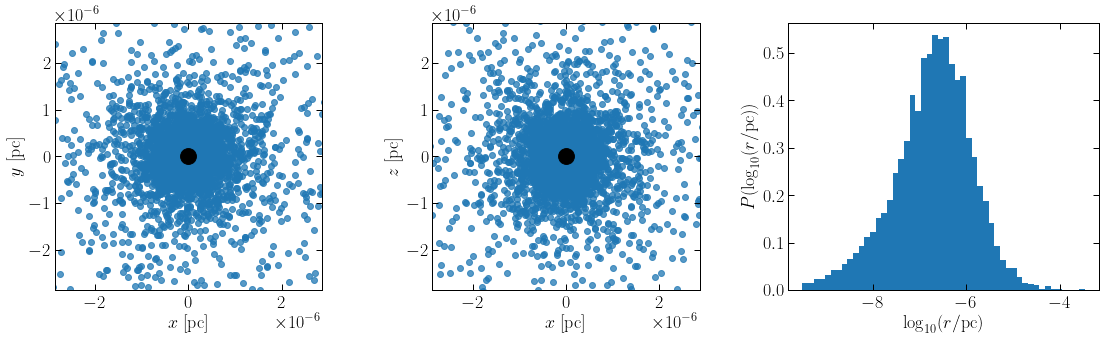

In [8]:
p_trunc = particles.single_BH(M_1, N_DM = N_DM, rho_6 = rho_6, gamma_sp = gamma_sp, r_max = 1e-2*u.pc, r_t = 2000*r_isco, alpha=2)

p_trunc.summary()
p_trunc.plot()

Now let's simulate again:

In [9]:
#Note that the simulator object remembers the state of the particle set stored in internal memory, 
#so we want to reinstantiate every time we want to restart the simulation from the beginning.
sim_trunc = simulator.simulator(p_trunc, r_soft_sq1 = eps1**2)
sim_trunc.run_simulation(dt, t_end, show_progress=True)

  0%|          | 26/10000 [00:00<00:38, 259.27it/s]

> Simulating...


100%|██████████| 10000/10000 [00:40<00:00, 249.12it/s]

> Simulation completed.


(<Figure size 1152x360 with 3 Axes>,
 array([<AxesSubplot:xlabel='$x$ [pc]', ylabel='$y$ [pc]'>,
        <AxesSubplot:xlabel='$x$ [pc]', ylabel='$z$ [pc]'>,
        <AxesSubplot:xlabel='$\\log_{10}(r/\\mathrm{pc})$', ylabel='$P(\\log_{10}(r/\\mathrm{pc}))$'>],
       dtype=object))

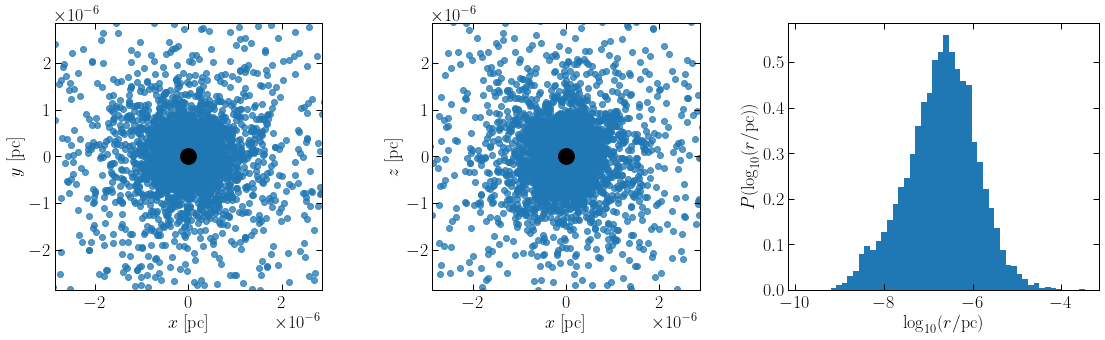

In [10]:
sim_trunc.p.plot()

Much better!

#### Reconstructing the density profile

We can reconstruct the DM density profile from a particle set `p`

In [11]:
def get_density_profile(p_in, bins = None):
    p = copy.deepcopy(p_in)
    rDM = tools.norm(p.xDM - p.xBH1)
    vDM = tools.norm(p.vDM - p.vBH1)
    
    r_isco = 6*u.G_N*p.M_1/u.c**2
    
    if bins is None:
        bins = np.geomspace(1, 1e5, 51)*r_isco
    
    #Bin edges and widths
    rc = np.sqrt(bins[:-1]*bins[1:])
    dr = np.diff(bins)
    
    #Reconstruct dn/dr
    nDM, _ = np.histogram(rDM, bins=bins)
    
    #Reconstruct rho = m_DM*dn/dV
    M_pseudo = p.M_DM[0]
    shell_volumes = (4*np.pi/3)*(bins[1:]**3 - bins[:-1]**3)
    rhoDM = M_pseudo*nDM/shell_volumes
    
    return rc, rhoDM

We're reconstruct the initial and final density profiles from the simulation above.

In [12]:
rc, rho_i = get_density_profile(p_trunc)
rc, rho_f = get_density_profile(sim_trunc.p)

Then we'll plot the density profiles (and their ratio):

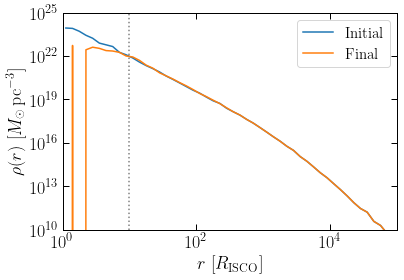

In [13]:
plt.figure()

plt.axvline(10*r_isco/r_isco, linestyle=':', color='gray')
#plt.axhline(1, linestyle='--', color='k')

plt.loglog(rc/r_isco, rho_i/(u.Msun/u.pc**3), label='Initial')
plt.semilogx(rc/r_isco, rho_f/(u.Msun/u.pc**3), label='Final')
plt.xlim(1, 1e5)
plt.ylim(1e10, 1e25)

plt.legend()

plt.xlabel(r"$r$ [$R_\mathrm{ISCO}$]")
plt.ylabel(r"$\rho(r)$ [$M_\odot \,\mathrm{pc}^{-3}$]")

plt.show()

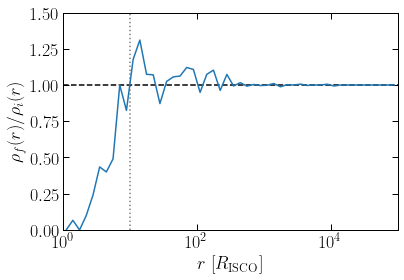

In [14]:
plt.figure()

plt.axvline(10*r_isco/r_isco, linestyle=':', color='gray')
plt.axhline(1, linestyle='--', color='k')

plt.semilogx(rc/r_isco, rho_f/rho_i)
plt.xlim(1, 1e5)
plt.ylim(0, 1.5)

plt.xlabel(r"$r$ [$R_\mathrm{ISCO}$]")
plt.ylabel(r"$\rho_f(r)/\rho_i(r)$")

plt.show()

Hmmm...looks like the density profile is suppressed at small radii, where softening with the central mass becomes important.

#### Spike in a softened potential

Let's now initialise the spike but pass in the softening length for the central BH. The distribution function will then be initialised properly taking into account the softened potential:

In [15]:
p_soft = particles.single_BH(M_1, N_DM = N_DM, rho_6 = rho_6, gamma_sp = gamma_sp, r_max = 1e-2*u.pc, r_t = 2000*r_isco, alpha=2, r_soft=eps1)

In [16]:
sim_soft = simulator.simulator(p_soft, r_soft_sq1 = eps1**2)
sim_soft.run_simulation(dt, t_end, show_progress=True)

  0%|          | 27/10000 [00:00<00:37, 265.01it/s]

> Simulating...


100%|██████████| 10000/10000 [00:42<00:00, 233.51it/s]

> Simulation completed.


In [17]:
rc, rho_soft_i = get_density_profile(p_soft)
rc, rho_soft_f = get_density_profile(sim_soft.p)

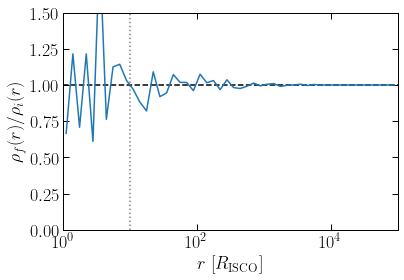

In [18]:
plt.figure()

plt.axvline(10*r_isco/r_isco, linestyle=':', color='gray')
plt.axhline(1, linestyle='--', color='k')

plt.semilogx(rc/r_isco, rho_soft_f/rho_soft_i)
plt.xlim(1, 1e5)
plt.ylim(0, 1.5)

plt.xlabel(r"$r$ [$R_\mathrm{ISCO}$]")
plt.ylabel(r"$\rho_f(r)/\rho_i(r)$")

plt.show()

There's a little numerical noise, but this is much better!